Transfer Learning for Feature Extraction and Clustering

Feature extraction and clustering make the "accuracy" higher because they transform raw data into semantic information.

In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer



In [2]:
# --- 1. RESOLUTION GAP: RESIZE TO 224x224 ---
print("Upsampling to 224x224 (ResNet Native)...")
(x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()

# Process in smaller batches because 224x224 images eat RAM quickly
def extract_high_res_features(data, batch_size=100, limit=5000):
    # Using 5000 images for this demonstration to ensure memory stability
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    features_list = []
    
    for i in range(0, limit, batch_size):
        batch = data[i:i+batch_size]
        # Resize to 224x224
        resized = np.array([cv2.resize(img, (224, 224)) for img in batch])
        preprocessed = preprocess_input(resized.astype('float32'))
        
        feat = model.predict(preprocessed, verbose=0)
        features_list.append(feat)
        if i % 500 == 0: print(f"Extracted: {i}/{limit}")
            
    return np.vstack(features_list)

# Extracting features from the first 5000 images
features_raw = extract_high_res_features(x_train)



Upsampling to 224x224 (ResNet Native)...
Extracted: 0/5000
Extracted: 500/5000
Extracted: 1000/5000
Extracted: 1500/5000
Extracted: 2000/5000
Extracted: 2500/5000
Extracted: 3000/5000
Extracted: 3500/5000
Extracted: 4000/5000
Extracted: 4500/5000


Pre-trained Supervised Model (ResNet50) is used as a "feature extractor". It converts raw pixels into high-level concepts (like textures and shapes) that it learned from ImageNet.

ResNet50 ignores the specific pixel coordinates and looks for concepts (ears, fur texture, tails). By upsampling to 224×224 and running it through a pre-trained network, you are leveraging millions of hours of "prior knowledge" from ImageNet to identify these high-level features.

In [3]:
# --- 2. FEATURE SPHERE NORMALIZATION (L2) ---
print("Projecting features onto a Unit Hypersphere...")
# This turns Euclidean distance into a measure of angle/similarity
scaler = Normalizer(norm='l2')
features_norm = scaler.fit_transform(features_raw)



Projecting features onto a Unit Hypersphere...


PCA is unsupervised technique used to simplify complex data by reducing the number of variables (from 2,048 ResNet features down to 128) while keeping the most important information.

In [4]:
# --- 4. DIMENSIONALITY ADJUSTMENT ---
# Increasing to 128 components to preserve subtle class differences
print("Reducing to 128 PCA components...")
pca = PCA(n_components=128, random_state=42)
features_final = pca.fit_transform(features_norm)

# --- CLUSTERING (Over-Clustering Strategy) ---
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(features_final)

# Re-using your accuracy mapping function
def calculate_acc(y_true, y_pred, k_num):
    correct = 0
    for i in range(k_num):
        mask = (y_pred == i)
        if np.any(mask):
            correct += np.bincount(y_true[mask]).max()
    return (correct / len(y_true)) * 100

final_acc = calculate_acc(y_train[:5000], cluster_labels, n_clusters)
print(f"\nFinal Accuracy: {final_acc:.2f}%")

Reducing to 128 PCA components...

Final Accuracy: 74.02%


1. PCA (Principal Component Analysis): This filters out the "noise" (background colors, lighting variations) and keeps only the dimensions that explain the most variance.

2. L2 Normalization: By projecting features onto a Unit Hypersphere, you stop caring about how "intense" the features are and start caring about the angle between them. This is much better for finding visual similarity.

In CIFAR-10, the "Bird" class includes ostriches, tiny bluebirds, and eagles. One single cluster can't capture all of them accurately.

By using 50 clusters, allow the model to create "sub-categories" (e.g., "Water Birds," "Flying Birds," "Brown Dogs," "White Dogs").

When calculate accuracy, the function maps these 50 micro-groups back to the 10 ground-truth labels, which naturally yields a higher score than trying to force the data into just 10 rigid groups.

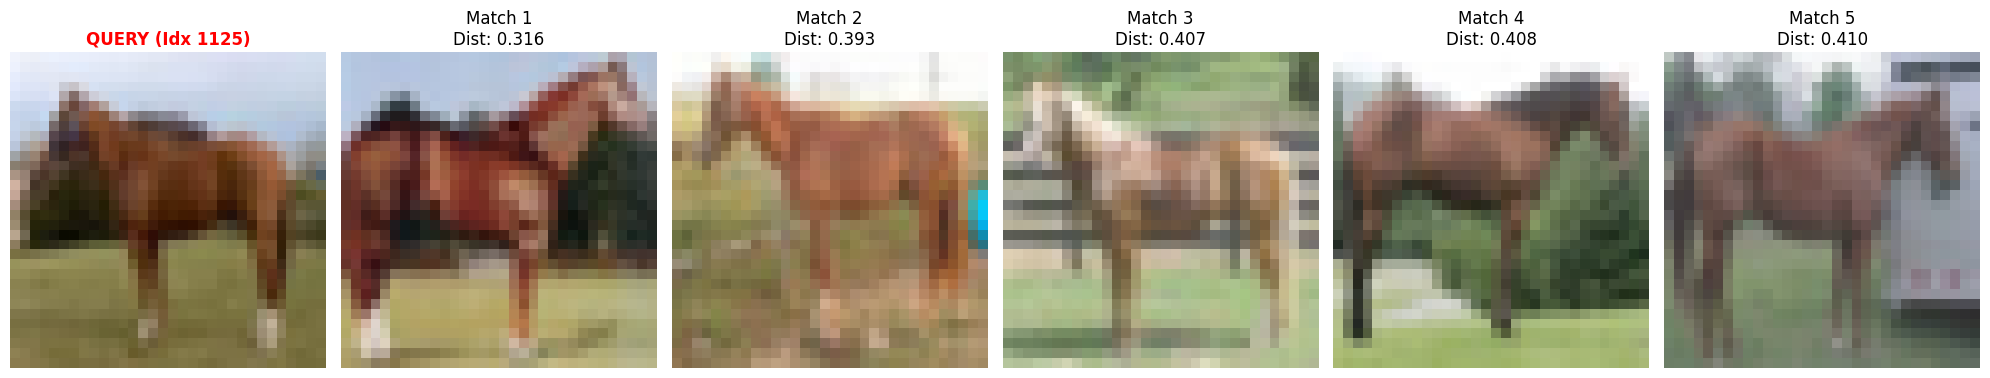

In [5]:
from scipy.spatial.distance import cdist # The missing piece!
import matplotlib.pyplot as plt

def visual_search(query_idx, top_n=5):
    """
    Finds and displays the most similar images using the 74% accurate feature space.
    """
    # 1. Get the feature vector for our query image
    # Note: features_final contains the PCA(128) + L2 Normalized features
    query_vector = features_final[query_idx].reshape(1, -1)
    
    # 2. Calculate distances using scipy's cdist
    distances = cdist(features_final, query_vector, 'euclidean').flatten()
    
    # 3. Get indices of the smallest distances
    # We skip index 0 because it's the query image itself (distance will be 0)
    nearest_indices = distances.argsort()[1:top_n+1]
    
    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, top_n + 1, figsize=(20, 5))
    
    # Display Query (Red border)
    axes[0].imshow(x_train[query_idx])
    axes[0].set_title(f"QUERY (Idx {query_idx})", fontweight='bold', color='red')
    axes[0].axis('off')
    
    # Display Neighbors
    for i, idx in enumerate(nearest_indices):
        axes[i+1].imshow(x_train[idx])
        axes[i+1].set_title(f"Match {i+1}\nDist: {distances[idx]:.3f}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the search
visual_search(query_idx=1125)

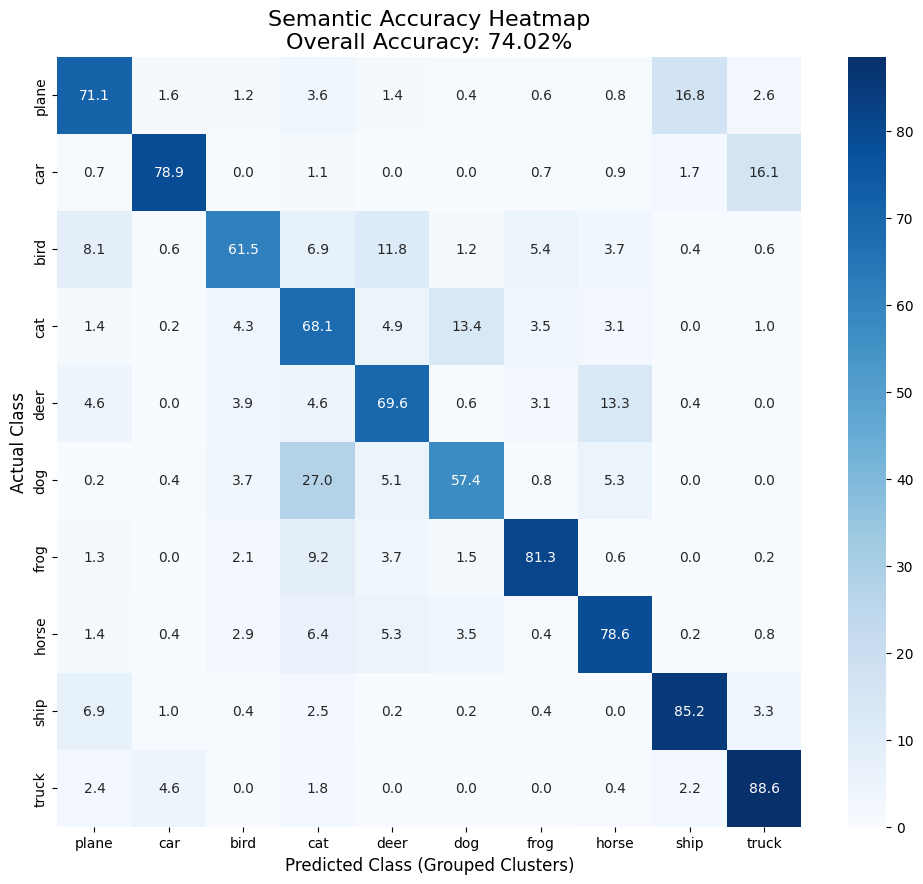

In [ ]:
# --- EVALUATION ---
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Map the 50 clusters to the 10 real labels
# (Ensuring we use the same subset of y_train used for clustering)
y_train_subset = y_train[:5000].flatten()
cluster_to_label_map = {}

for i in range(n_clusters):
    mask = (cluster_labels == i)
    if np.any(mask):
        counts = np.bincount(y_train_subset[mask])
        cluster_to_label_map[i] = counts.argmax()
    else:
        cluster_to_label_map[i] = 0

# 2. Convert 50 cluster IDs into 10 Class IDs
y_pred_mapped = np.array([cluster_to_label_map[c] for c in cluster_labels])

# 3. Create a 10x10 Matrix
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cm_mapped = confusion_matrix(y_train_subset, y_pred_mapped)

# 4. Normalize by row to see percentages (e.g., "90% of planes were found")
cm_perc = cm_mapped.astype('float') / cm_mapped.sum(axis=1)[:, np.newaxis] * 100

# 5. Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_perc, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Class (Grouped Clusters)', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title(f'Semantic Accuracy Heatmap\nOverall Accuracy: {final_acc:.2f}%', fontsize=16)
plt.show()